In [ ]:
# General Imports
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Building Model
from keras.utils import plot_model
from tensorflow.keras import models
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import legacy


In [ ]:
# Training Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint

# Data Processing
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import load_img

In [ ]:
# Global variables
SAVE = False
SEED = 111

# Setting seed for consistent results
tf.keras.utils.set_random_seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

# Data Visualization updates
%config InlineBackend.figure_format = 'retina'
plt.rcParams["figure.figsize"] = (16, 10)
plt.rcParams.update({'font.size': 14})

# Data Classifications
CLASS_TYPES = ['pituitary', 'notumor', 'meningioma', 'glioma']
N_TYPES = len(CLASS_TYPES)

In [ ]:
import os
from sklearn.preprocessing import LabelEncoder

def get_data_labels(data_dir):
    # Lists to hold paths and labels
    data_paths = []
    data_labels = []

    # Loop through the directories and subdirectories
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir):  # Check if it is a directory
            for file in os.listdir(label_dir):
                file_path = os.path.join(label_dir, file)
                if file_path.endswith(('.png', '.jpg', '.jpeg')):  # Add your image extensions
                    data_paths.append(file_path)
                    data_labels.append(label)  # Store the label

    return data_paths, data_labels


In [ ]:
import os
import zipfile

# Path to the ZIP file
USER_PATH = r"/content/braintumorclassification.zip"

# Extract the ZIP file
with zipfile.ZipFile(USER_PATH, 'r') as zip_ref:
    zip_ref.extractall("/content")  # Extract to a specific directory, e.g., /content

# Now set the correct paths to the training and testing directories
train_dir = "/content/Training/"  # Adjust based on the extracted folder structure
test_dir = "/content/Testing/"      # Adjust based on the extracted folder structure

# Define the function to get data and labels
def get_data_labels(data_dir):
    data_paths = []
    data_labels = []
    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)
        if os.path.isdir(label_dir):
            for file in os.listdir(label_dir):
                file_path = os.path.join(label_dir, file)
                if file_path.endswith(('.png', '.jpg', '.jpeg')):  # Specify image extensions
                    data_paths.append(file_path)
                    data_labels.append(label)
    return data_paths, data_labels

# Getting data using the function
train_paths, train_labels = get_data_labels(train_dir)
test_paths, test_labels = get_data_labels(test_dir)

# Printing training and testing sample sizes
print('Training')
print(f'Number of Paths: {len(train_paths)}')
print(f'Number of Labels: {len(train_labels)}')
print('\nTesting')
print(f'Number of Paths: {len(test_paths)}')
print(f'Number of Labels: {len(test_labels)}')


Training
Number of Paths: 5712
Number of Labels: 5712

Testing
Number of Paths: 1311
Number of Labels: 1311


x reshaped: (1, 150, 150, 3)


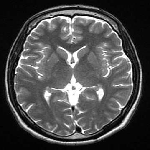

In [ ]:
# getting image to test output
im = load_img(train_paths[3], target_size=(150, 150))
im = img_to_array(im)

# Reshape it to (1, 150, 150, 3)
im = np.expand_dims(im, axis=0)
print(f'x reshaped: {im.shape}')

# normilzation tensor
im /= np.max(im) # ~ np.max(img_tensor)

# Convert the array back to the image format
im = array_to_img(im[0])
display(im)

In [ ]:
# Image size
image_size = (150, 150)

# Training batch size
batch_size = 32

In [ ]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002,
                                   height_shift_range=0.002,
                                   shear_range=12.5,
                                   zoom_range=0,
                                   horizontal_flip=True,
                                   vertical_flip=False,
                                   fill_mode="nearest")


# applying the generator to training data with constant seed
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode="categorical",
                                                    seed=SEED)


# No augmentation of the test data, just rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# applying the generator to testing data with constant seed
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=image_size,
                                                  batch_size=batch_size,
                                                  class_mode="categorical",
                                                  shuffle=False,
                                                  seed=SEED)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [ ]:
# Accessing class indices for training data generator
class_indices_train = train_generator.class_indices
class_indices_train_list = list(train_generator.class_indices.keys())


# Displaying categorical types
print("Categorical types for the training data:")
print(class_indices_train)

Categorical types for the training data:
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


In [ ]:
# Image shape: height, width, RBG
image_shape = (image_size[0], image_size[1], 3)

# Training epochs
epochs = 40

# Steps per epoch
steps_per_epoch = train_generator.samples // batch_size

# Validation steps
validation_steps = test_generator.samples // batch_size

print(f'Image shape: {image_shape}')
print(f'Epochs: {epochs}')
print(f'Batch size: {batch_size}')
print(f'Steps Per Epoch: {steps_per_epoch}')
print(f'Validation steps: {validation_steps}')

Image shape: (150, 150, 3)
Epochs: 40
Batch size: 32
Steps Per Epoch: 178
Validation steps: 40


In [ ]:
# Define the model architecture
model = models.Sequential([

    # Convolutional layer 1
    Conv2D(32, (4, 4), activation="relu", input_shape=image_shape),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 2
    Conv2D(64, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 3
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),

    # Convolutional layer 4
    Conv2D(128, (4, 4), activation="relu"),
    Flatten(),

    # Full connect layers
    Dense(512, activation="relu"),
    Dropout(0.5, seed=SEED),
    Dense(N_TYPES, activation="softmax")
])
model.summary()
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001, beta_1=0.869, beta_2=0.995)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)                    │ (None, 147, 147, 32)        │           1,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 49, 49, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 46, 46, 64)          │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 15, 15, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 12, 12, 128)         │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_8 (MaxPooling2D)       │ (None, 4, 4, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 1, 1, 128)           │         262,272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 495,972 (1.89 MB)

 Trainable params: 495,972 (1.89 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Stop training if loss doesn't keep decreasing.
model_es = EarlyStopping(monitor='loss', min_delta=1e-9, patience=8, verbose=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=5, verbose=True)

# Training the model
history = model.fit(train_generator,
                    steps_per_epoch=steps_per_epoch,
                    epochs=epochs,
                    validation_data=test_generator,
                    validation_steps=validation_steps,
                    callbacks=[model_es, model_rlr])

Epoch 1/40


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


178/178 ━━━━━━━━━━━━━━━━━━━━ 57s 276ms/step - accuracy: 0.4835 - loss: 1.0822 - val_accuracy: 0.7523 - val_loss: 0.6474 - learning_rate: 0.0010
Epoch 2/40
  1/178 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.8125 - loss: 0.4513

/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8125 - loss: 0.4513 - val_accuracy: 0.9032 - val_loss: 0.5245 - learning_rate: 0.0010
Epoch 3/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 67s 230ms/step - accuracy: 0.7873 - loss: 0.5286 - val_accuracy: 0.7492 - val_loss: 0.6347 - learning_rate: 0.0010
Epoch 4/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7188 - loss: 0.7634 - val_accuracy: 0.9677 - val_loss: 0.2553 - learning_rate: 0.0010
Epoch 5/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 81s 228ms/step - accuracy: 0.8296 - loss: 0.4234 - val_accuracy: 0.7898 - val_loss: 0.4934 - learning_rate: 0.0010
Epoch 6/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 234us/step - accuracy: 0.6562 - loss: 0.6481 - val_accuracy: 1.0000 - val_loss: 0.0194 - learning_rate: 0.0010
Epoch 7/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 83s 229ms/step - accuracy: 0.8747 - loss: 0.3332 - val_accuracy: 0.8219 - val_loss: 0.4774 - learning_rate: 0.0010
Epoch 8/40
178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 278us/step - accuracy: 0.9375 - loss: 0.2877 

In [ ]:
# Evaluating the model
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples//batch_size)
print(f"Test Loss: {loss:0.5f}")
print(f"Test Accuracy: {accuracy:0.5f}")

40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 47ms/step - accuracy: 0.9657 - loss: 0.1160
Test Loss: 0.08589
Test Accuracy: 0.97578


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix as sk_confusion_matrix

def CM(CNN_model, test_generator, categories):
    # Predict the classes
    y_true = test_generator.classes  # True labels
    y_pred = np.argmax(CNN_model.predict(test_generator), axis=1)  # Predicted labels

    # Compute the confusion matrix
    cm = sk_confusion_matrix(y_true, y_pred)

    return cm


In [ ]:
# Save the model in HDF5 format
model.save('brain_tumor_classification_model.h5')


In [ ]:
# Save the model in native Keras format
model.save('brain_tumor_classification_model.keras')


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step


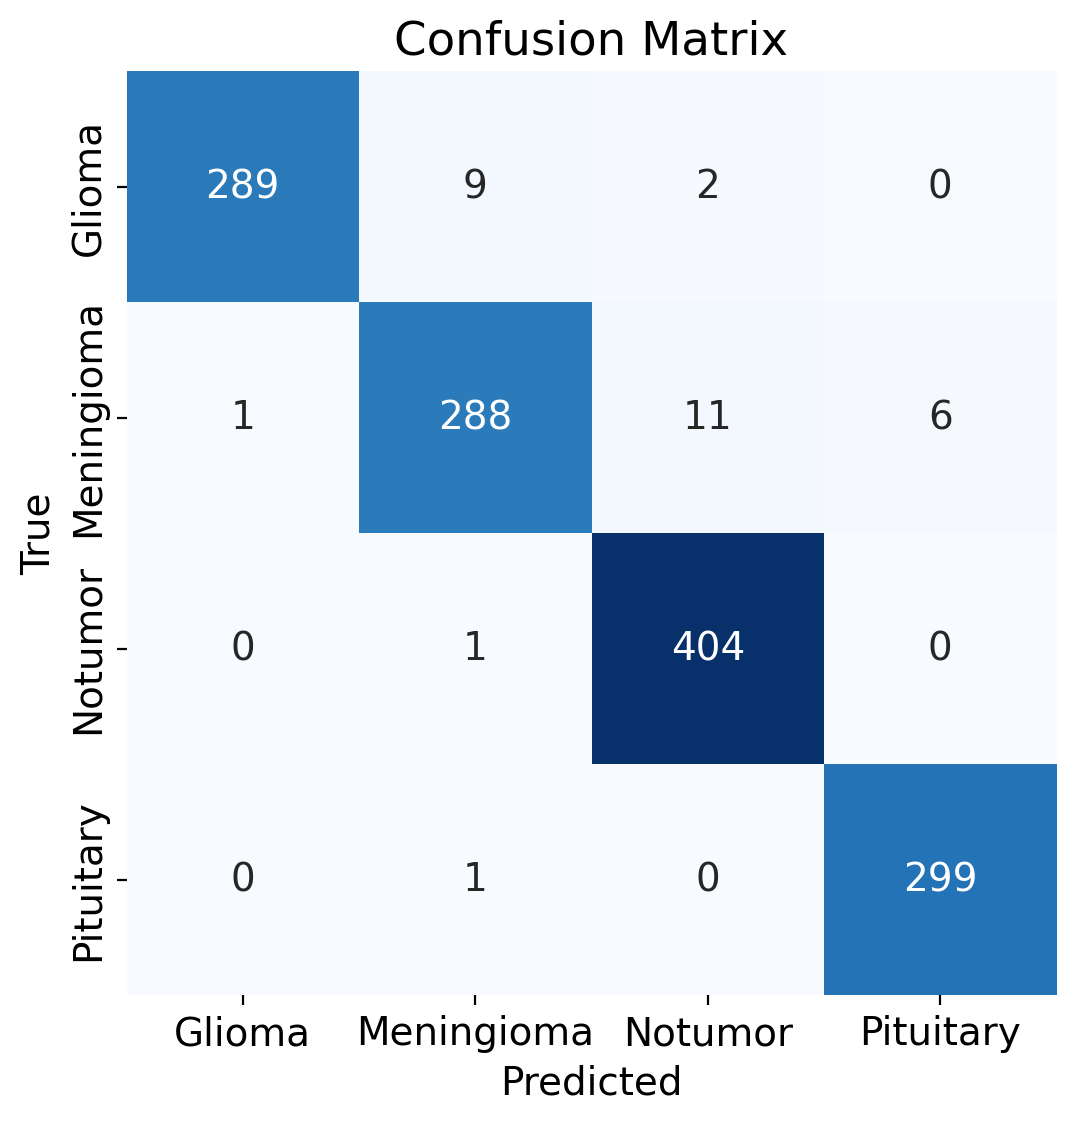

In [ ]:
# Plotting confusion matrix
confusion_matrix = CM(CNN_model=model, test_generator=test_generator, categories=class_indices_train_list)

plt.figure(figsize=(6,6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(N_TYPES) + 0.5,
           labels=[name.title() for name in class_indices_train_list], ha='center')
plt.yticks(ticks=np.arange(N_TYPES) + 0.5,
           labels=[name.title() for name in class_indices_train_list], va='center')
plt.show()

In [ ]:
# Save the model in native Keras format
model.save('brain_tumor_classification_model.keras')

In [ ]:
def calculate_metrics(confusion_matrix, categories):

    # Calculate true positives, false positives, false negatives
    tp = np.diag(confusion_matrix)  # True positives for each class
    fp = np.sum(confusion_matrix, axis=0) - tp  # False positives for each class
    fn = np.sum(confusion_matrix, axis=1) - tp  # False negatives for each class

    # Calculate metrics
    accuracy = np.sum(tp) / np.sum(confusion_matrix)
    precision = tp / (tp + fp)  # Precision for each class
    recall = tp / (tp + fn)      # Recall for each class
    f1_score = 2 * (precision * recall) / (precision + recall)

    # Create a metrics dictionary
    metrics = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1_score,
    }

    # Print the metrics in the desired format
    for category, prec, rec, f1 in zip(categories, precision, recall, f1_score):
        print(f"Class: {category.capitalize()}")
        print(f"Precision: {prec:.3f}")
        print(f"Recall: {rec:.3f}")
        print(f"F1-Score: {f1:.3f}\n")

    print(f"Overall Accuracy: {accuracy:.3f}")

    return metrics


In [ ]:
# Assuming confusion_matrix is obtained from your earlier CM function
metrics = calculate_metrics(confusion_matrix, categories=class_indices_train_list)

# Optionally, display the metrics dictionary
print(metrics)


Class: Glioma
Precision: 0.997
Recall: 0.963
F1-Score: 0.980

Class: Meningioma
Precision: 0.963
Recall: 0.941
F1-Score: 0.952

Class: Notumor
Precision: 0.969
Recall: 0.998
F1-Score: 0.983

Class: Pituitary
Precision: 0.980
Recall: 0.997
F1-Score: 0.988

Overall Accuracy: 0.976
{'accuracy': 0.9763539282990084, 'precision': array([0.99655172, 0.9632107 , 0.96882494, 0.98032787]), 'recall': array([0.96333333, 0.94117647, 0.99753086, 0.99666667]), 'f1_score': array([0.97966102, 0.95206612, 0.98296837, 0.98842975])}
